# Protein measurements in single cell data

Additionally to capturing only transcriptomic data with single cell analyses, we are now able to also capture the abundance of surface protein expression. The protocol used for this is usually referred to as CITE-seq{cite}`Stoeckius_Hafemeister_Stephenson_Houck-Loomis_Chattopadhyay_Swerdlow_Satija_Smibert_2017`. This modality requires different preprocessing compared to what we described in section \link{preprocessing} as data distributions are different. In the following, we will guide you through the preprocess of dealing with CITE-seq data.

## Introduction

Single-cell RNA-seq data acts as a proxy for protein level with a partial correlation at various transcription estates of a cell{cite}`Liu_Beyer_Aebersold_2016`. Therefore, it is in our interest to measure the protein levels in single-cells if we are to capture a better picture of cellular processes. Quantifying these aspects of a cell is essential to understand cell differentiation and fate, cell signal transduction pathway, disease progression, perturbations, and clinical diagnostics{cite}`Xie_Ding`.

We can already detect relevant populations with single-cell transcriptomics. This is a valuable piece of information, but incomplete if we want to better understand the cellular identities and dynamics happening in the biological processes we study. Having surface protein measurements allows us to close the gap between identity by transcription and identity by protein where there might be a delay in synthesis that could be important in our experiment. For example, it has been noted that ICOS, an immune checkpoint protein, was increased on the surface of treated cells, regardless of the fact that this protein’s mRNA does not differ in abundance between the treatment groups{cite}`Peterson_Zhang_Kumar_Wong_Li_Wilson_Moore_McClanahan_Sadekova_Klappenbach_2017`. Another advantage is that surface protein levels help us detect doublets that might not be reflected at the transcript level in our data. This is possible by looking at the co-occurrence of cell-type-specific markers{cite}`Sun_Bugarin-Estrada_Overend_Walker_Tucci_Bashford-Rogers_2021`.

By using antibodies tagged with a barcode, it is possible to first bind the antibodies to the cells and later sequence the barcodes together with the RNA. There are two main protocols CITE-seq (Cellular Indexing of Transcriptomes and Epitopes by Sequencing) and REAP-seq (RNA expression and protein sequencing assay). The main difference resides in their antibody-oligo conjugates also known as Antibody-Derived Tags (ADT). CITE-seq uses streptavidin that is noncovalently bound to biotinylated DNA barcodes. REAP-seq implements covalent bonds between the antibody and aminated DNA barcode{cite}`Peterson_Zhang_Kumar_Wong_Li_Wilson_Moore_McClanahan_Sadekova_Klappenbach_2017`. urthermore, there has been advances integrating the CITE-seq protocol in a multimodal assay. One is DOGMA-seq{cite}`Mimitou_Lareau_Chen_Zorzetto-Fernandes_Hao_Takeshima_Luo_Huang_Yeung_Papalexi_et al._2021`, an adaptation of CITE-seq that allows the measurement of chromatin accessibility, gene expression, and protein from the same cell. The other is ASAP-seq, which combines scATAC-seq and ADT by adding a bridge oligo specific to the CITE-seq reagents{cite}`KEY`. We will refer to these protein measurements as ADT data.

![CITE-Seq](https://citeseq.files.wordpress.com/2017/10/antibody_transparent.png)

With ADT data, we can identify cell types based on conventional markers usually utilised in flow cytometry experiments. These markers are especially useful for specific immune cell populations. The advantage of ADT is that other modalities are measured simultaneously. However, the way we process ADT data differs from others. Contrary to the negative binomial distribution of UMI counts,  it follows a different distribution. Also, ADT data is noisier, as unbound antibodies lead to counts in cells or empty droplets where the protein is not present. Initially, ADT data was simply normalised using the Centred Log-Ratio (CLR) transformation. Nevertheless, a new low-level normalization method tailored to dealing with the challenges this modality poses now exists: dsb (denoised and scaled by background). The dsb normalization removes two kinds of noise. First, it uses the empty droplets to estimate a background noise and remove the ambient noise. Secondly, it uses the background population mean and isotypes (antibodies that bind nonspecifically to the cells) to define and remove cell-to-cell technical noise{cite}`Mulè_Martins_Tsang_2022`.

## About the data

Here we are analysing ADT data obtained from bone marrow mononuclear cells (BMMCs){cite}`KEY`. It contains 136 surface protein and 4 isotypes.

In this chapter we will use scanpy and muon to analyse the data. We show you how to load, perform quality control, normalize, and do some basic visualization. We also show a way to remove batch effect.

## Environment setup

In [1]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import harmonypy as hm

/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

We're reading in the data with muon. This way we already have two subobjects, one for RNA and another for ADT.

We use glob with a regular expression to get the file paths for the individual samples.

We read in the filtered objects, in which cell calling by Cell Ranger is already performed as well as the unfiltered objects.

In [2]:
data_path = '/storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/cite/s*d*/cellranger_out/'

In [3]:
filtered_files = glob.glob(data_path + 'filtered_*/')

In [4]:
raw_files = glob.glob(data_path + 'raw_*/')

As Mudata does not support concatenation, we need to use the scanpy function for this. We split each object into a GEX and an ADT anndata object, concatenate those individually and finally attach them to a new joint MuData object.

We do this for both the filtered and the raw object.

In [5]:
%%time
filtered_mu = {}
for i in filtered_files:
    name = i.split('/')[8]
    filtered_mu[name]=mu.read_10x_mtx(i)
    filtered_mu[name]['prot'].obs['donor']=name
    filtered_mu[name]['rna'].obs['donor']=name
    
filtered = filtered_mu.pop('s1d1')
filtered_rna = filtered['rna']
filtered_prot = filtered['prot']
for i in filtered_mu.keys():
    filtered_rna = filtered_rna.concatenate(filtered_mu[i]['rna'])
    filtered_prot = filtered_prot.concatenate(filtered_mu[i]['prot'])
filtered = mu.MuData({'rna':filtered_rna, 'prot': filtered_prot})
del filtered_mu

CPU times: user 8min, sys: 7.71 s, total: 8min 8s
Wall time: 8min 14s


In [6]:
%%time
raw_mu = {}
for i in raw_files:
    name = i.split('/')[8]
    raw_mu[name]=mu.read_10x_mtx(i)
    raw_mu[name]['prot'].obs['donor']=name
    raw_mu[name]['rna'].obs['donor']=name
    
raw = raw_mu.pop('s1d1')
raw_rna = raw['rna']
raw_prot = raw['prot']
for i in raw_mu.keys():
    raw_rna = raw_rna.concatenate(raw_mu[i]['rna'])
    raw_prot = raw_prot.concatenate(raw_mu[i]['prot'])
raw = mu.MuData({'rna':raw_rna, 'prot': raw_prot})
del raw_mu

CPU times: user 42min 17s, sys: 2min 29s, total: 44min 47s
Wall time: 46min 39s


Now, we have two Mudata objects. One with the called cells and one with all cell barcodes.

In [7]:
filtered

MuData object with n_obs × n_vars = 122016 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	122016 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	122016 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

In [8]:
raw

MuData object with n_obs × n_vars = 24807643 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	24807643 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	24807643 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

## Quality Control

Similar to transcriptomics data QC and filtering, we need to preprocess ADT data. Empty droplets still contain reads for ADT counts because unbound antibodies are sequenced. We can, however make use of these empty droplets to normalise our count data as we can consider this as the ambient background level for each antibody.

In [9]:
filtered['prot'].X

<122016x140 sparse matrix of type '<class 'numpy.float32'>'
	with 14267923 stored elements in Compressed Sparse Row format>

In [10]:
sc.pp.calculate_qc_metrics(filtered['prot'], inplace=True, percent_top=None)

In [11]:
sc.pp.calculate_qc_metrics(raw['prot'], inplace=True, percent_top=None)

We first look at the distribution of ADTs per cell over all samples. We plot this using the seaborn library.

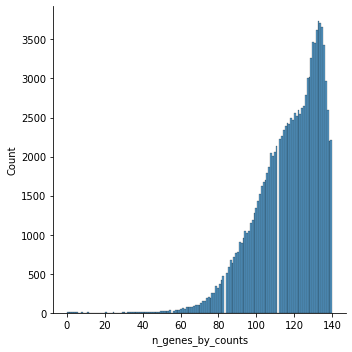

In [12]:
sns.displot(filtered['prot'].obs.n_genes_by_counts)

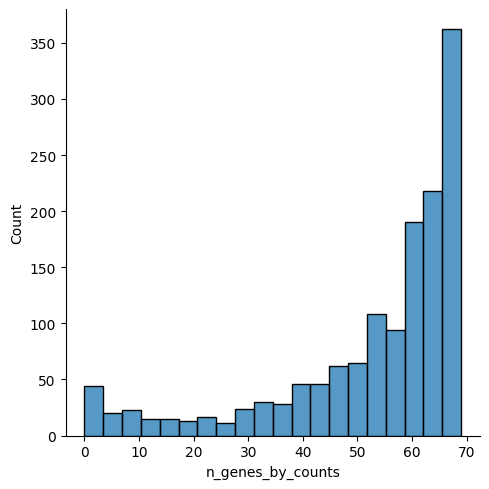

In [13]:
sns.displot(filtered['prot'][filtered['prot'].obs.n_genes_by_counts<70].obs.n_genes_by_counts)

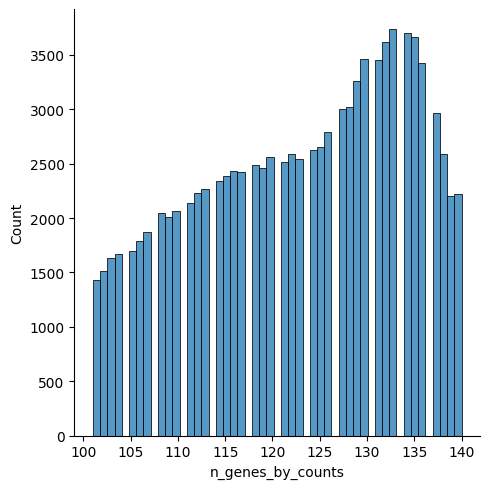

In [14]:
sns.displot(filtered['prot'][filtered['prot'].obs.n_genes_by_counts>100].obs.n_genes_by_counts)

We can see a 'valley' in the distribution at around 55 ADTs. This looks like an appropriate cutoff.

Next, we do the same thing based on total counts per cell.

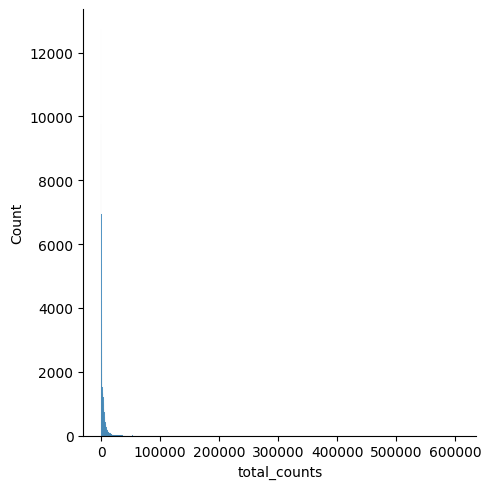

In [15]:
sns.displot(filtered['prot'].obs.total_counts)

We zoom in to see the upper end of the distribution for the total counts to decide on a cutoff for the maximum number of counts.

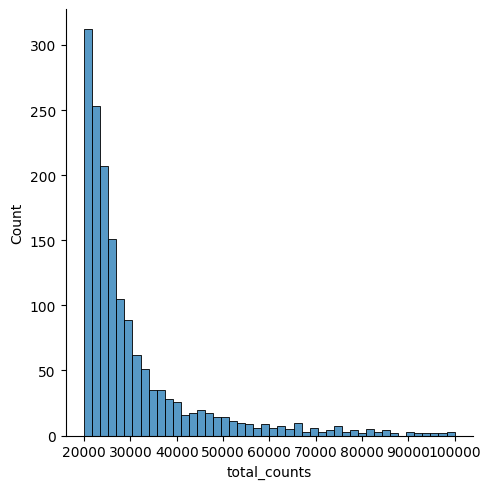

In [16]:
sns.displot(filtered['prot'].obs.query('total_counts>20000 and total_counts<100000').total_counts)

### Sample-wise QC

Now we look at the distribution of counts per cell across the samples to see if there are differences.

In [17]:
sc.pp.filter_cells(filtered['prot'], max_counts=100000)

<AxesSubplot:xlabel='donor', ylabel='total_counts'>

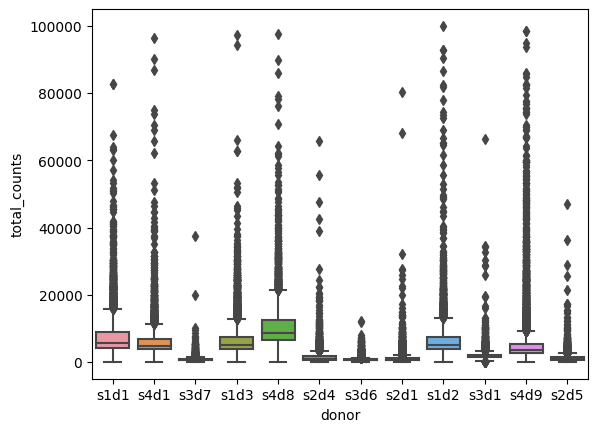

In [18]:
sns.boxplot(y=filtered['prot'].obs.total_counts, x=filtered['prot'].obs['donor'])

The distributions of counts are different between samples. Thus, sample-wise QC is deemed pertinent.

Since we have significant number of samples we can do sample-wise QC automatically as described in the RNA preprocessing chapter.

In [19]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (np.median(M) + nmads * M.mad() < M)
    return outlier

In [20]:
%%time
outliers = []
for sample in np.unique(filtered['prot'].obs['donor']):
    adata_temp = filtered['prot'][filtered['prot'].obs['donor'] == sample].copy()
    adata_temp.obs['outlier'] = is_outlier(adata_temp, 'log1p_total_counts', 5) | is_outlier(adata_temp, 'log1p_n_genes_by_counts', 5)
    outliers.append(adata_temp.obs['outlier'])
    print(
        f"{sample}: outliers {adata_temp.obs.outlier.value_counts()[True]}"
    )

s1d1: outliers 116
s1d2: outliers 103
s1d3: outliers 100
s2d1: outliers 132
s2d4: outliers 102
s2d5: outliers 104
s3d1: outliers 180
s3d6: outliers 206
s3d7: outliers 177
s4d1: outliers 81
s4d8: outliers 41
s4d9: outliers 137
CPU times: user 320 ms, sys: 4.02 ms, total: 324 ms
Wall time: 324 ms


In [21]:
filtered['prot'].obs['outliers'] = pd.concat(outliers)

In [22]:
filtered['prot'].obs

donor batch  n_genes_by_counts  \
AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0  s1d1     0                124   
AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0  s1d1     0                140   
AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0  s1d1     0                120   
AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0  s1d1     0                128   
AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0  s1d1     0                114   
...                                        ...   ...                ...   
TTTGTTGCATGTCAGT-1-1                      s2d5     1                 82   
TTTGTTGGTCACTACA-1-1                      s2d5     1                 94   
TTTGTTGGTGCGGTAA-1-1                      s2d5     1                 79   
TTTGTTGTCGGATACT-1-1                      s2d5     1                 89   
TTTGTTGTCGTCCTTG-1-1                      s2d5     1                110   

                                          log1p_n_genes_by_counts  \
AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0                 4.828314   
AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0                 4.948760   
AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0                 4.795791   
AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0                 4.859812   
AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0                 4.744932   
...                                                           ...   
TTTGTTGCATGTCAGT-1-1                                     4.418841   
TTTGTTGGTCACTACA-1-1                                     4.553877   
TTTGTTGGTGCGGTAA-1-1                                     4.382027   
TTTGTTGTCGGATACT-1-1                                     4.499810   
TTTGTTGTCGTCCTTG-1-1                                     4.709530   

                                          total_counts  log1p_total_counts  \
AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0        6483.0            8.777093   
AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0       19711.0            9.888983   
AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0        3349.0            8.116715   
AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0        7841.0            8.967249   
AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0        2462.0            7.809135   
...                                                ...                 ...   
TTTGTTGCATGTCAGT-1-1                             307.0            5.730100   
TTTGTTGGTCACTACA-1-1                             602.0            6.401917   
TTTGTTGGTGCGGTAA-1-1                             413.0            6.025866   
TTTGTTGTCGGATACT-1-1                             529.0            6.272877   
TTTGTTGTCGTCCTTG-1-1                             925.0            6.830874   

                                          n_counts  outliers  
AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0    6483.0     False  
AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0   19711.0     False  
AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0    3349.0     False  
AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0    7841.0     False  
AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0    2462.0     False  
...                                            ...       ...  
TTTGTTGCATGTCAGT-1-1                         307.0     False  
TTTGTTGGTCACTACA-1-1                         602.0     False  
TTTGTTGGTGCGGTAA-1-1                         413.0     False  
TTTGTTGTCGGATACT-1-1                         529.0     False  
TTTGTTGTCGTCCTTG-1-1                         925.0     False  

[121981 rows x 8 columns]

In [23]:
filtered.update()

In [24]:
filtered = filtered[filtered.obs.loc[filtered['prot'].obs_names].index]

In [25]:
filtered = filtered[filtered['prot'].obs['outliers']==False]

NOTE: I think we should use the same plot before and after filtering because that would be more comparable.

<AxesSubplot:xlabel='donor', ylabel='total_counts'>

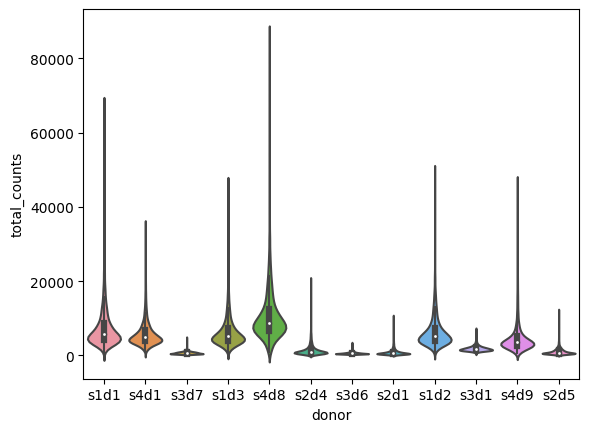

In [26]:
sns.violinplot(y=filtered['prot'].obs.total_counts, x=filtered['prot'].obs['donor'], scale='width')

/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='n_genes_by_counts', ylabel='total_counts'>

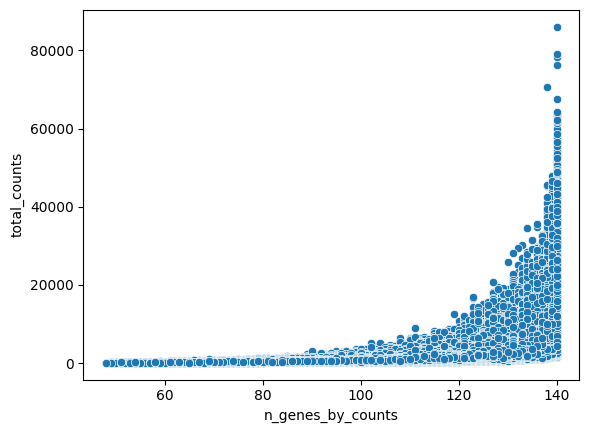

In [27]:
sns.scatterplot(filtered['prot'].obs.n_genes_by_counts, filtered['prot'].obs.total_counts)

In [28]:
filtered

View of MuData object with n_obs × n_vars = 120502 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	120502 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	120502 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalisation

We are ready to normalize the data. In this case, we can use the raw data's distribution as background. We also have isotype controls to define and remove cell-to-cell technical variations.

We are calling the normalization function `mu.prot.pp.dsb` with the filtered and raw mudata object as well as the names of the isotype controls.

In [29]:
isotype_controls = ['Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b']

In [30]:
filtered['prot'].layers['counts'] = filtered['prot'].X

In [31]:
%%time
mu.prot.pp.dsb(filtered, raw, isotype_controls=isotype_controls)

/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/muon/_prot/preproc.py:110: UserWarning: empty_counts_range values are not provided, treating all the non-cells as empty droplets
  "empty_counts_range values are not provided, treating all the non-cells as empty droplets"


CPU times: user 10min 50s, sys: 12.4 s, total: 11min 3s
Wall time: 11min 4s


In [32]:
pd.Series(filtered['prot'].layers['counts'][:100,:100].A.flatten()).value_counts()

1.0      1090
0.0      1045
2.0       918
3.0       691
4.0       581
         ... 
350.0       1
706.0       1
296.0       1
970.0       1
763.0       1
Length: 524, dtype: int64

In [33]:
pd.Series(filtered['prot'].X[:100,:100].flatten()).value_counts()

-0.995182    1
 2.121016    1
 0.750427    1
 7.009898    1
-0.534120    1
            ..
-0.382648    1
-0.806136    1
 0.154715    1
 0.284685    1
-0.264200    1
Length: 10000, dtype: int64

If you don't have the unfiltered data available, you can also normalize the ADT data with `mu.prot.pp.clr`, implementing Centered Log-Ratio normalization.

In [34]:
filtered

View of MuData object with n_obs × n_vars = 120502 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	120502 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	120502 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      layers:	'counts'

You don't need the isotypes for the next steps

In [35]:
filtered['prot'].var.index[:50]

Index(['CD86-1', 'CD274-1', 'CD270', 'CD155', 'CD112', 'CD47-1', 'CD48-1',
       'CD40-1', 'CD154', 'CD52-1', 'CD3', 'CD8', 'CD56', 'CD19-1', 'CD33-1',
       'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7-1', 'CD105', 'CD49f',
       'CD194', 'CD4-1', 'CD44-1', 'CD14-1', 'CD16', 'CD25', 'CD45RO', 'CD279',
       'TIGIT-1', 'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b',
       'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5-1', 'CD195',
       'CD32', 'CD196', 'CD185', 'CD103', 'CD69-1', 'CD62L', 'CD161'],
      dtype='object')

In [36]:
temp = filtered['prot'].var.loc[~filtered['prot'].var.index.isin(isotype_controls),:].index
temp

Index(['CD86-1', 'CD274-1', 'CD270', 'CD155', 'CD112', 'CD47-1', 'CD48-1',
       'CD40-1', 'CD154', 'CD52-1',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E-1', 'CD82-1',
       'CD101-1', 'CD88', 'CD224'],
      dtype='object', length=136)

We store the isotype data as a multi-dimensional annotation.

In [37]:
filtered['prot'].obsm['X_isotypes'] = filtered['prot'].X[:,~filtered['prot'].var.index.isin(temp.tolist())]

In [38]:
mu.pp.filter_var(data=filtered['prot'], var=temp.tolist())

In [39]:
filtered['prot'].var.index[:50]

Index(['CD86-1', 'CD274-1', 'CD270', 'CD155', 'CD112', 'CD47-1', 'CD48-1',
       'CD40-1', 'CD154', 'CD52-1', 'CD3', 'CD8', 'CD56', 'CD19-1', 'CD33-1',
       'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7-1', 'CD105', 'CD49f',
       'CD194', 'CD4-1', 'CD44-1', 'CD14-1', 'CD16', 'CD25', 'CD45RO', 'CD279',
       'TIGIT-1', 'CD20', 'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM',
       'CD5-1', 'CD195', 'CD32', 'CD196', 'CD185', 'CD103', 'CD69-1', 'CD62L',
       'CD161', 'CD152', 'CD223', 'KLRG1-1', 'CD27-1'],
      dtype='object')

## Dimensionality reduction and visualisation

We can now reduce the dimensionality of the data with PCA, compute a neighborhood graph and a UMAP emdedding to visualise the study's variables.

In [40]:
sc.pp.pca(filtered['prot'], svd_solver='arpack')

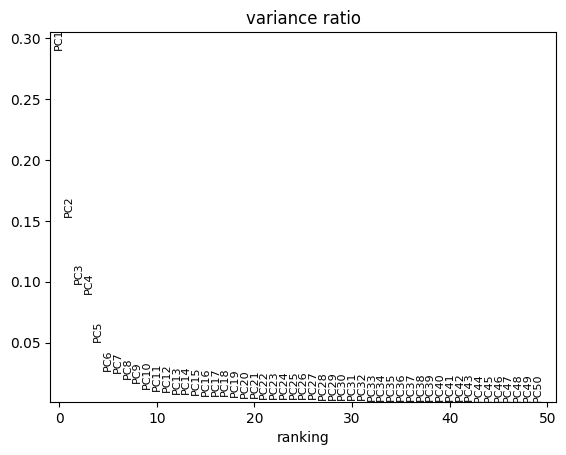

In [41]:
sc.pl.pca_variance_ratio(filtered['prot'], n_pcs = 50)

In [42]:
%%time
sc.pp.neighbors(filtered['prot'], n_pcs=30)

CPU times: user 38.1 s, sys: 719 ms, total: 38.8 s
Wall time: 32.1 s


In [43]:
%%time
sc.tl.umap(filtered['prot'])

CPU times: user 3min 5s, sys: 4 s, total: 3min 9s
Wall time: 2min 42s


/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


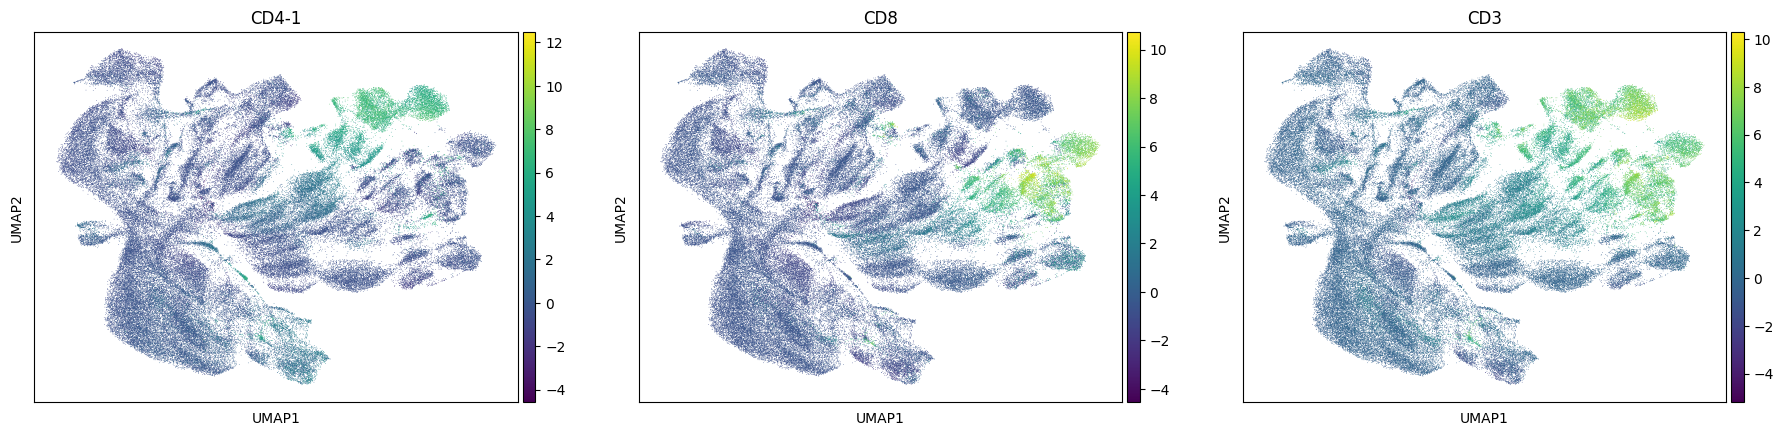

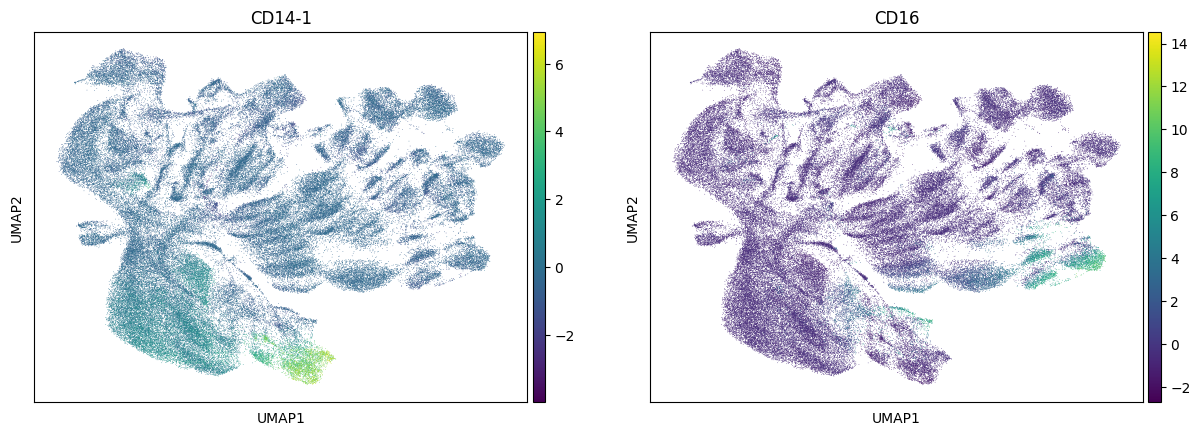

In [44]:
sc.pl.umap(filtered['prot'], color=['CD4-1', 'CD8', 'CD3'])
sc.pl.umap(filtered['prot'], color=['CD14-1', 'CD16'])

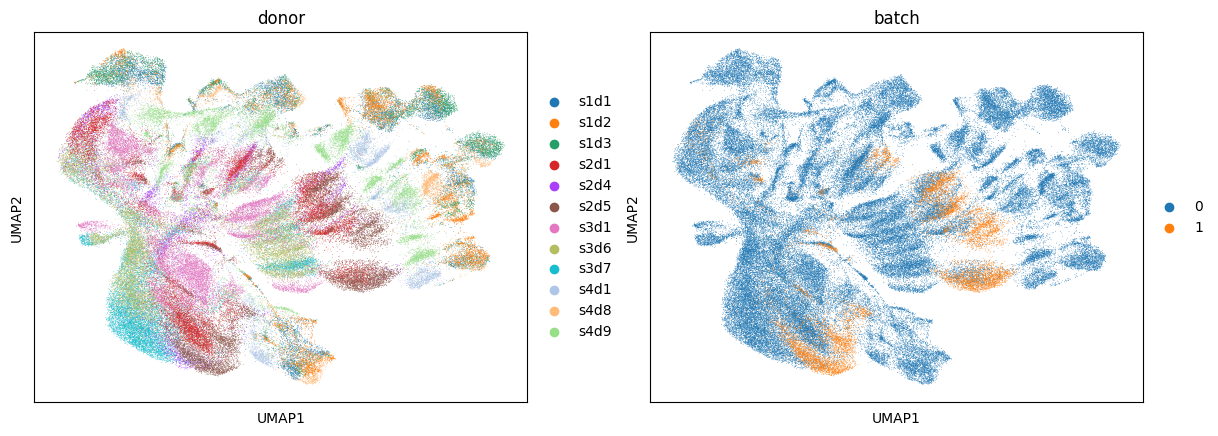

In [45]:
sc.pl.umap(filtered['prot'], color=['donor','batch'])

As it can be seen in the above UMAP representation, different samples cluster apart from each other for similar populations (see CD4 and CD8 expression in the previous plot). Thus, batch correction of the data would be necessary.

## Batch correction

We can use harmony to perform batch correction of the data.

In [46]:
%%time
ho = hm.run_harmony(filtered['prot'].X, filtered['prot'].obs, ['donor'])

2022-06-21 15:46:02,387 - harmonypy - INFO - Iteration 1 of 10
2022-06-21 15:47:39,663 - harmonypy - INFO - Iteration 2 of 10
2022-06-21 15:49:19,368 - harmonypy - INFO - Iteration 3 of 10
2022-06-21 15:50:58,779 - harmonypy - INFO - Iteration 4 of 10
2022-06-21 15:52:38,239 - harmonypy - INFO - Iteration 5 of 10
2022-06-21 15:54:17,387 - harmonypy - INFO - Iteration 6 of 10
2022-06-21 15:55:56,597 - harmonypy - INFO - Iteration 7 of 10
2022-06-21 15:57:35,664 - harmonypy - INFO - Iteration 8 of 10
2022-06-21 15:58:39,054 - harmonypy - INFO - Converged after 8 iterations


CPU times: user 19min 9s, sys: 7min 18s, total: 26min 27s
Wall time: 14min 6s


In [47]:
pc_std = np.std(ho.Z_corr,axis=1).tolist()

<AxesSubplot:>

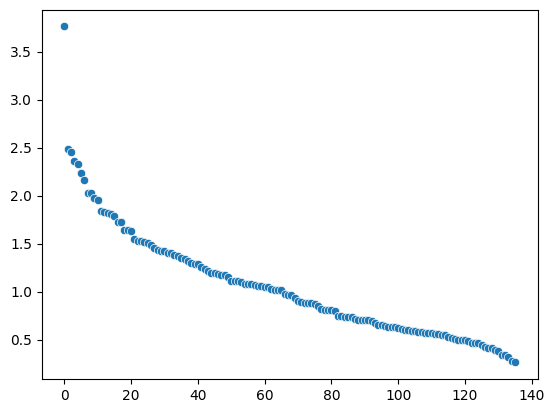

In [48]:
sns.scatterplot(x=range(0,len(pc_std)), y=sorted(pc_std, reverse=True))

In [49]:
filtered['prot'].obsm['X_pcahm'] = ho.Z_corr.transpose()

In [50]:
filtered['prot'].obsm

AxisArrays with keys: X_isotypes, X_pca, X_umap, X_pcahm

In [51]:
%%time
sc.pp.neighbors(filtered['prot'], n_pcs=30, use_rep="X_pcahm")
sc.tl.umap(filtered['prot'])

CPU times: user 3min 41s, sys: 5.55 s, total: 3min 46s
Wall time: 3min 8s


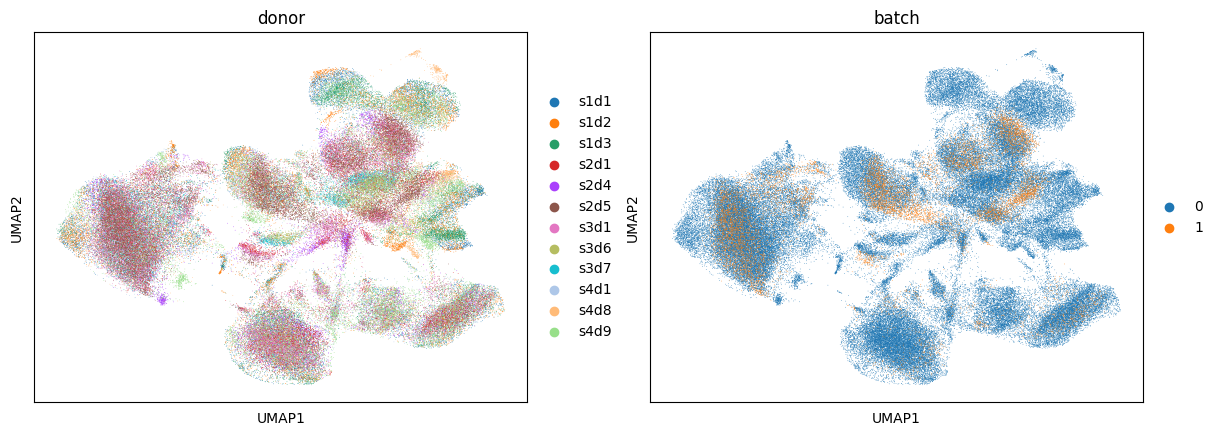

In [52]:
sc.pl.umap(filtered['prot'], color=['donor','batch'])

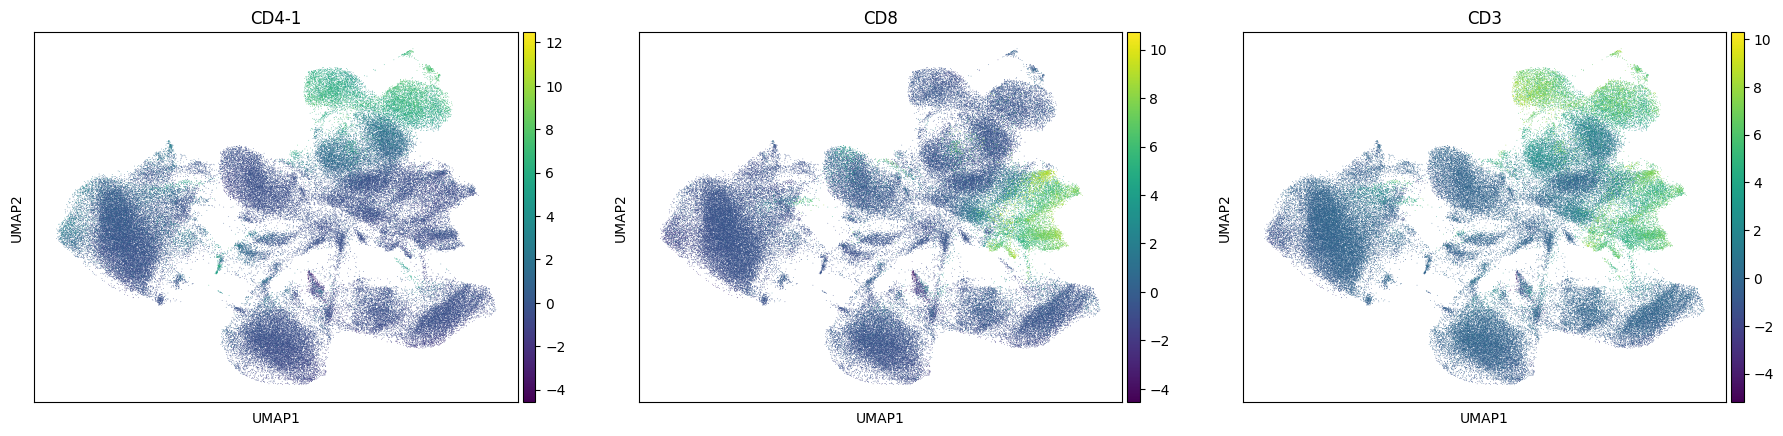

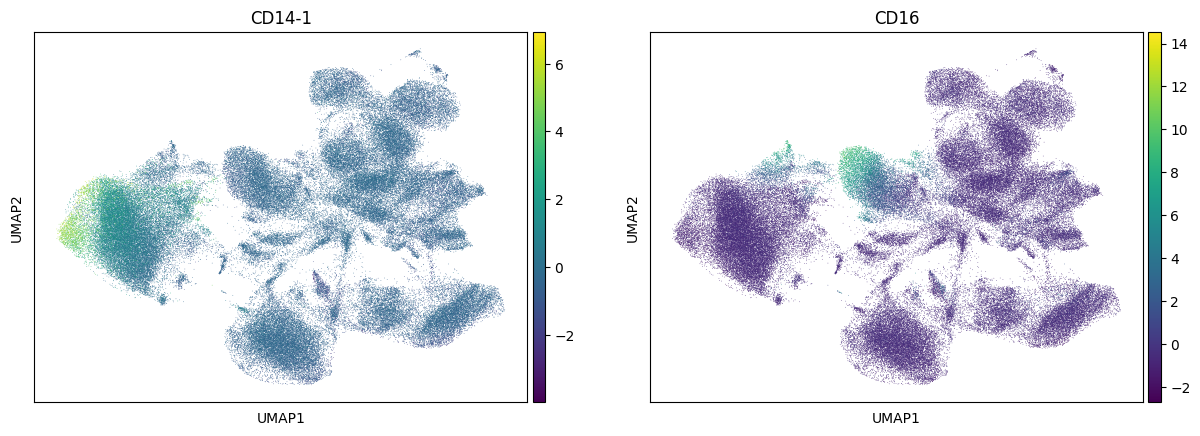

In [53]:
sc.pl.umap(filtered['prot'], color=['CD4-1', 'CD8', 'CD3'])
sc.pl.umap(filtered['prot'], color=['CD14-1', 'CD16'])

You can use this UMAP representation for interpretation. You can also simply use the ADT levels to interpret another embedding obtained from another modality.